# Experimento Efeito Fotoeléctrico

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.constants import h as plancks, e
from scipy.interpolate import interp1d

h = plancks / e

In [286]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 120
sns.set_theme()

#### Constanstes e funções

In [424]:
colors  		= [ 'red', 'yellow', 'green', 'blue', 'violet' ]
colors_			= [ 'red', 'orange', 'green', 'blue', 'violet' ]
cores   		= [ 'Vermelho', 'Laranja', 'Verde', 'Azul', 'Violeta' ]
intensities		= [ 20, 40, 60, 80, 100 ]

In [288]:
def gaussian(x, A, m, s): return A * np.exp( - (x - m)**2 / (2 * s**2) )

## Espectro de emissão dos LEDs

In [432]:
df_leds = {}
for color in colors: df_leds[color] = pd.read_csv(f'Dados/LEDs/{color}.dat', sep='\t')

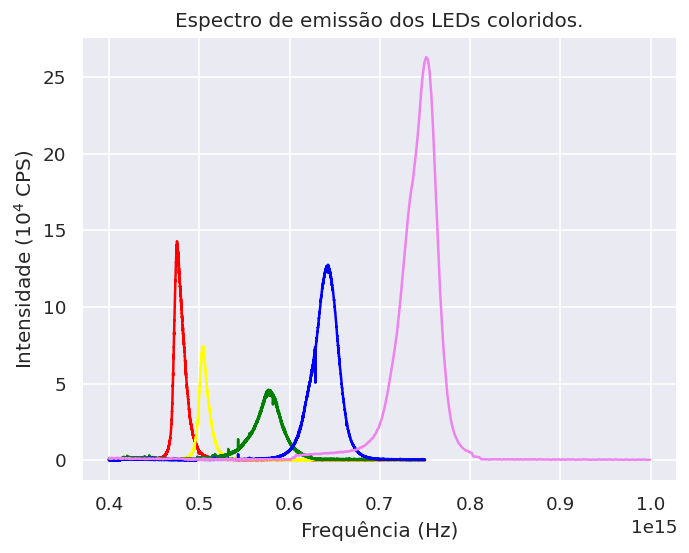

In [433]:
plt.title('Espectro de emissão dos LEDs coloridos.')

for color in colors: sns.lineplot(x=df_leds[color]['Frequencia'], y=df_leds[color]['Intensidade']/1E4, color=color)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade ($10^{4}$ CPS)')

plt.savefig('Plots/leds_emission.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [20]:
peaks = []
heights = [ 14.2E4, 7.45E4, 4.6E4, 12.75E4, 25E4 ]
for i,color in enumerate(colors):
	peaks.append( list(df_leds[color]['Frequencia'][ find_peaks(df_leds[color]['Intensidade'], height=heights[i])[0] ])[0] )

In [21]:
np.array(peaks) / 1E14

array([4.75402, 5.0406 , 5.77017, 6.42416, 7.5134 ])

In [22]:
ranges  = [ [3400, 4000], [2900, 3350], [1600, 2300], [800, 1500], [90, 115] ]
hints   = [
    [ 15E4,  peaks[0], 0.1E14 ],
    [ 7E4,   peaks[1], 0.1E14 ],
    [ 5E4,   peaks[2], 0.1E14 ],
    [ 13E4,  peaks[3], 0.1E14 ],
    [ 21E4,  peaks[4], 0.1E14 ]
  ]
params = {}

In [23]:
for i,color in enumerate(colors):
  popt, pcov = curve_fit(
      gaussian,
      xdata=df_leds[color]['Frequencia'][ranges[i][0]:ranges[i][1]],
      ydata=df_leds[color]['Intensidade'][ranges[i][0]:ranges[i][1]],
      p0=hints[i],
      maxfev=10000
  )
  params[color] = popt

In [24]:
leds_frequency = np.zeros((5, 2))
for i,param in enumerate(params):
  leds_frequency[i] = params[param][1:3]

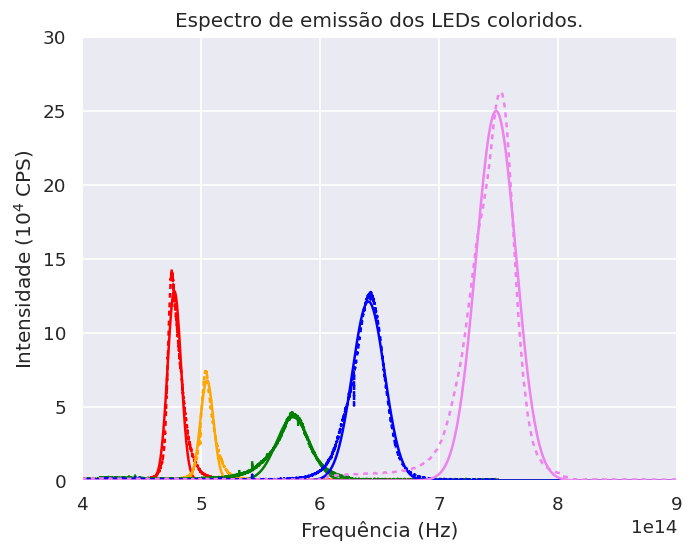

In [471]:
plt.title('Espectro de emissão dos LEDs coloridos.')

x = np.linspace(0.4, 1, 1000) * 1E15

for i,color in enumerate(colors):
  sns.lineplot(x=x, y=gaussian(x, params[color][0], params[color][1], params[color][2])/1E4, color=colors_[i])
  sns.lineplot(x=df_leds[color]['Frequencia'], y=df_leds[color]['Intensidade']/1E4, dashes=(2,2), color=colors_[i])

plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade ($10^{4}$ CPS)')
plt.xlim(0.4E15, 0.9E15)
plt.ylim(0, 30)

plt.savefig('Plots/leds_emission_fits.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

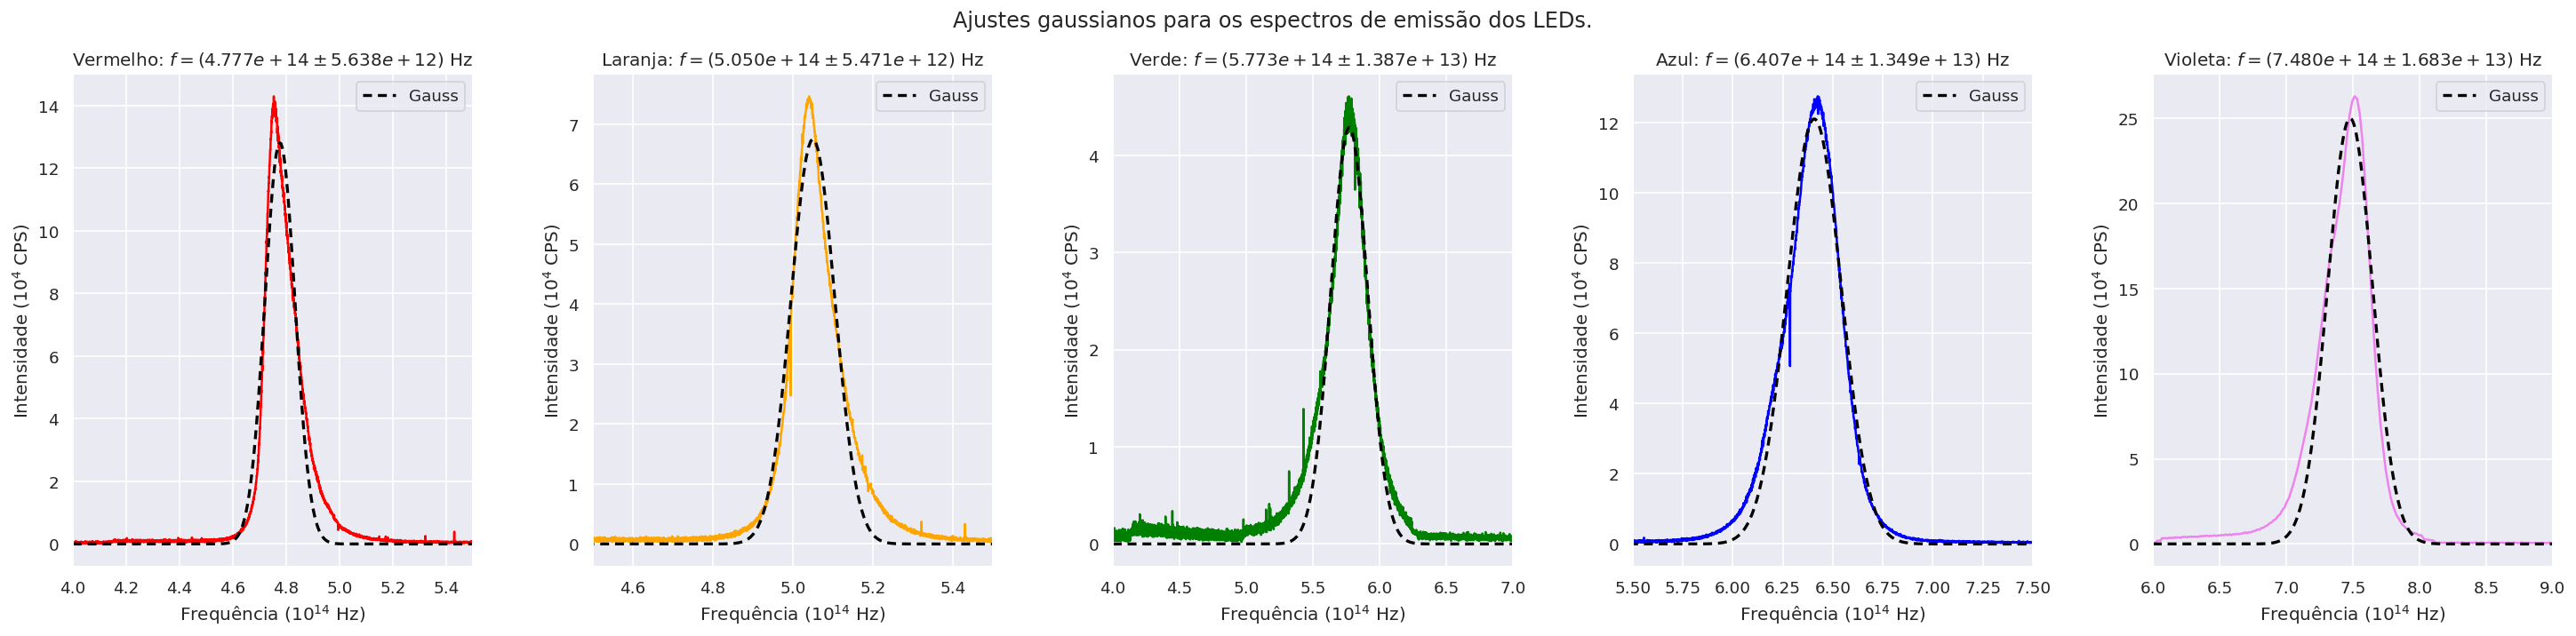

In [470]:
fig, axs = plt.subplots(1, 5, figsize=(30,6), gridspec_kw={ 'wspace': 0.3 })
plt.suptitle('Ajustes gaussianos para os espectros de emissão dos LEDs.')

x = np.linspace(0.4, 1, 1000) * 1E15

xlims = [ [4, 5.5], [4.5, 5.5], [4, 7], [5.5, 7.5], [6, 9] ]
for i,color in enumerate(colors):
	sns.lineplot(x=df_leds[color]['Frequencia']/1E14, y=df_leds[color]['Intensidade']/1E4, color=colors_[i], ax=axs[i])
	sns.lineplot(
		x=x/1E14, 
		y=gaussian(x, params[color][0], params[color][1], params[color][2])/1E4, 
		dashes=(3, 2), alpha=1, color='black', linewidth=2, ax=axs[i],
		label='Gauss'
	)
	# axs[i].vlines(x=[ df_leds[color]['Frequencia'][ranges[i][0]]/1E14, df_leds[color]['Frequencia'][ranges[i][1]]/1E14 ], ymin=0, ymax=15, color='gray', linestyles='dashed')
	axs[i].set(xlim=xlims[i], title=f'{cores[i]}: $f=({params[color][1]:.3e}\pm{params[color][2]:.3e})$ Hz', xlabel='Frequência ($10^{14}$ Hz)', ylabel='Intensidade ($10^4$ CPS)')

plt.savefig('Plots/leds_emission_fits_subplots.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Curvas de intensidade medidas

In [289]:
df_raw = pd.read_csv('Dados/dados.csv')

### Correção do ruído

Carregamos os dados das médias de 10 medidas para cada intensidade de cada cor de LED e aplicamos a correção da corrente parasita.

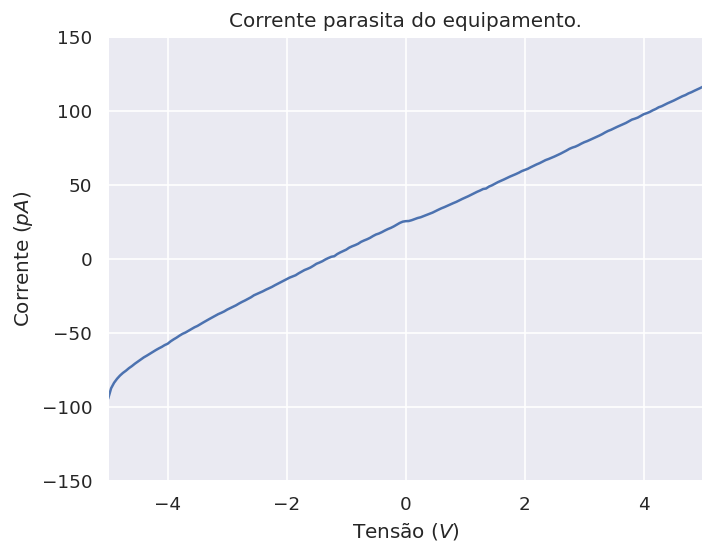

In [436]:
plt.title('Corrente parasita do equipamento.')

sns.lineplot(x=df_raw['Tensao'], y=df_raw['Ruido']*1E12)

plt.xlim(-5, 5)
plt.ylim(-150, 150)
plt.ylabel('Corrente ($p A$)')
plt.xlabel('Tensão ($V$)')

plt.savefig('Plots/curve_noise.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [309]:
df = pd.DataFrame(df_raw)
df.drop(columns=[ 'Ruido', 'sRuido' ], inplace=True)

In [310]:
for cor in cores:
	for i in intensities:
		df[f'{cor}_{i}'] = df_raw[f'{cor}_{i}'] - df_raw['Ruido']
		df[f's{cor}_{i}'] = np.sqrt( df_raw[f's{cor}_{i}']**2 + df_raw['sRuido']**2 )

### Curvas dos LEDS

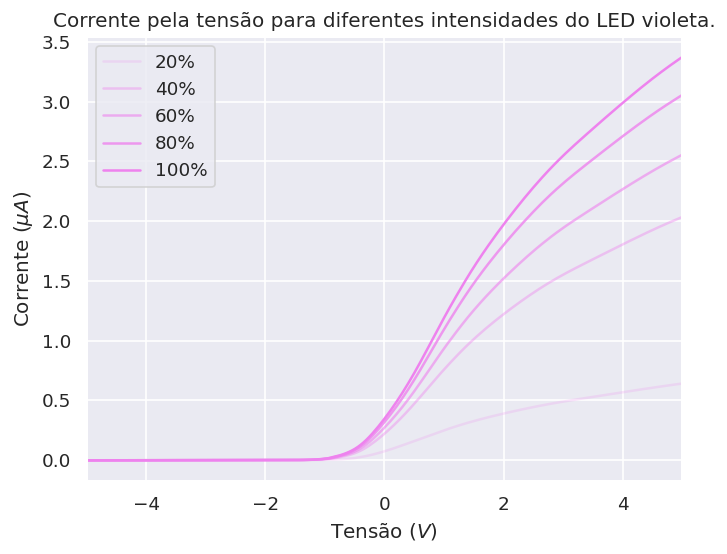

In [437]:
plt.title('Corrente pela tensão para diferentes intensidades do LED violeta.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Violeta_{i}']*1E6, alpha=i/100, color='violet', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_violet.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

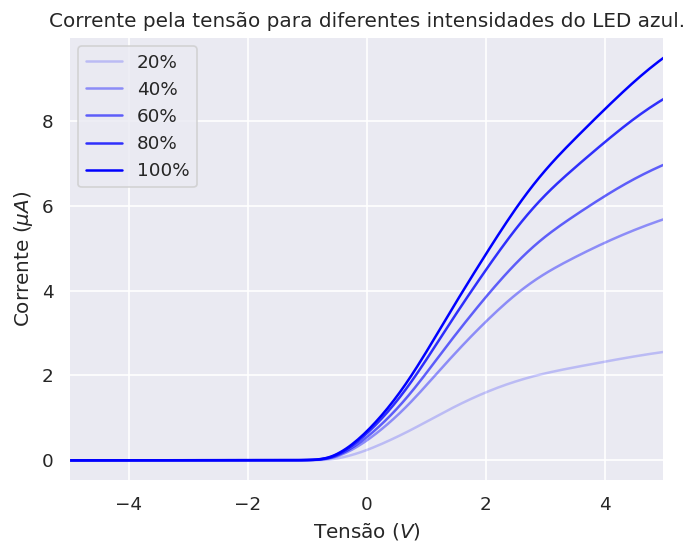

In [438]:
plt.title('Corrente pela tensão para diferentes intensidades do LED azul.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Azul_{i}']*1E6, alpha=i/100, color='blue', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_blue.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

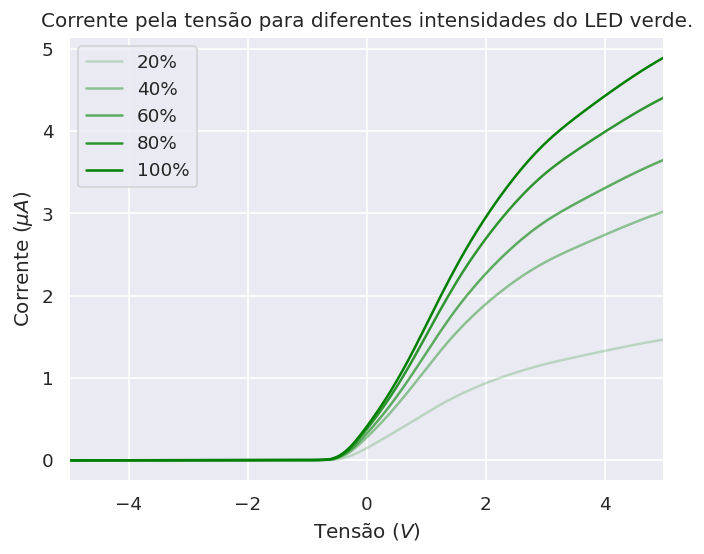

In [439]:
plt.title('Corrente pela tensão para diferentes intensidades do LED verde.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Verde_{i}']*1E6, alpha=i/100, color='green', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_green.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

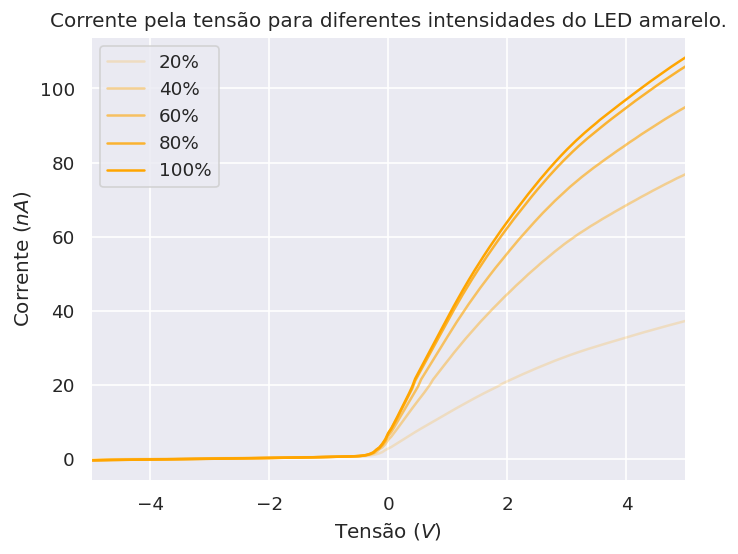

In [440]:
plt.title('Corrente pela tensão para diferentes intensidades do LED amarelo.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Laranja_{i}']*1E9, alpha=i/100, color='orange', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($nA$)')

plt.savefig('Plots/curve_yellow.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

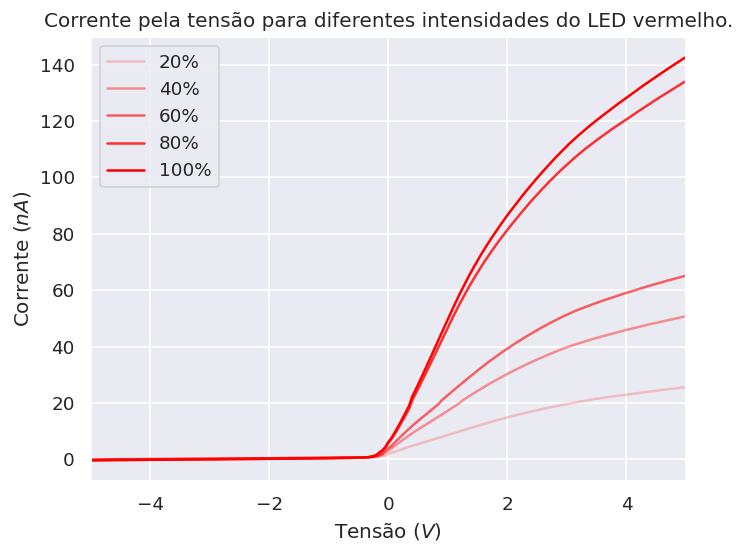

In [441]:
plt.title('Corrente pela tensão para diferentes intensidades do LED vermelho.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Vermelho_{i}']*1E9, alpha=i/100, color='red', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($nA$)')

plt.savefig('Plots/curve_red.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Estudo da tensão de corte $V_0$

A tensão de corte é definida como a diferença de potencial em que a intensidade da corrente que circula pelo aparelho é nula. Portanto, sua incerteza dependerá das incertezas da intensidade e da tensão e também do método utilizado para determiná-la.

### Método 1

Para o primeiro método, determinamos o ponto em que a série cruza o eixo-$x$.

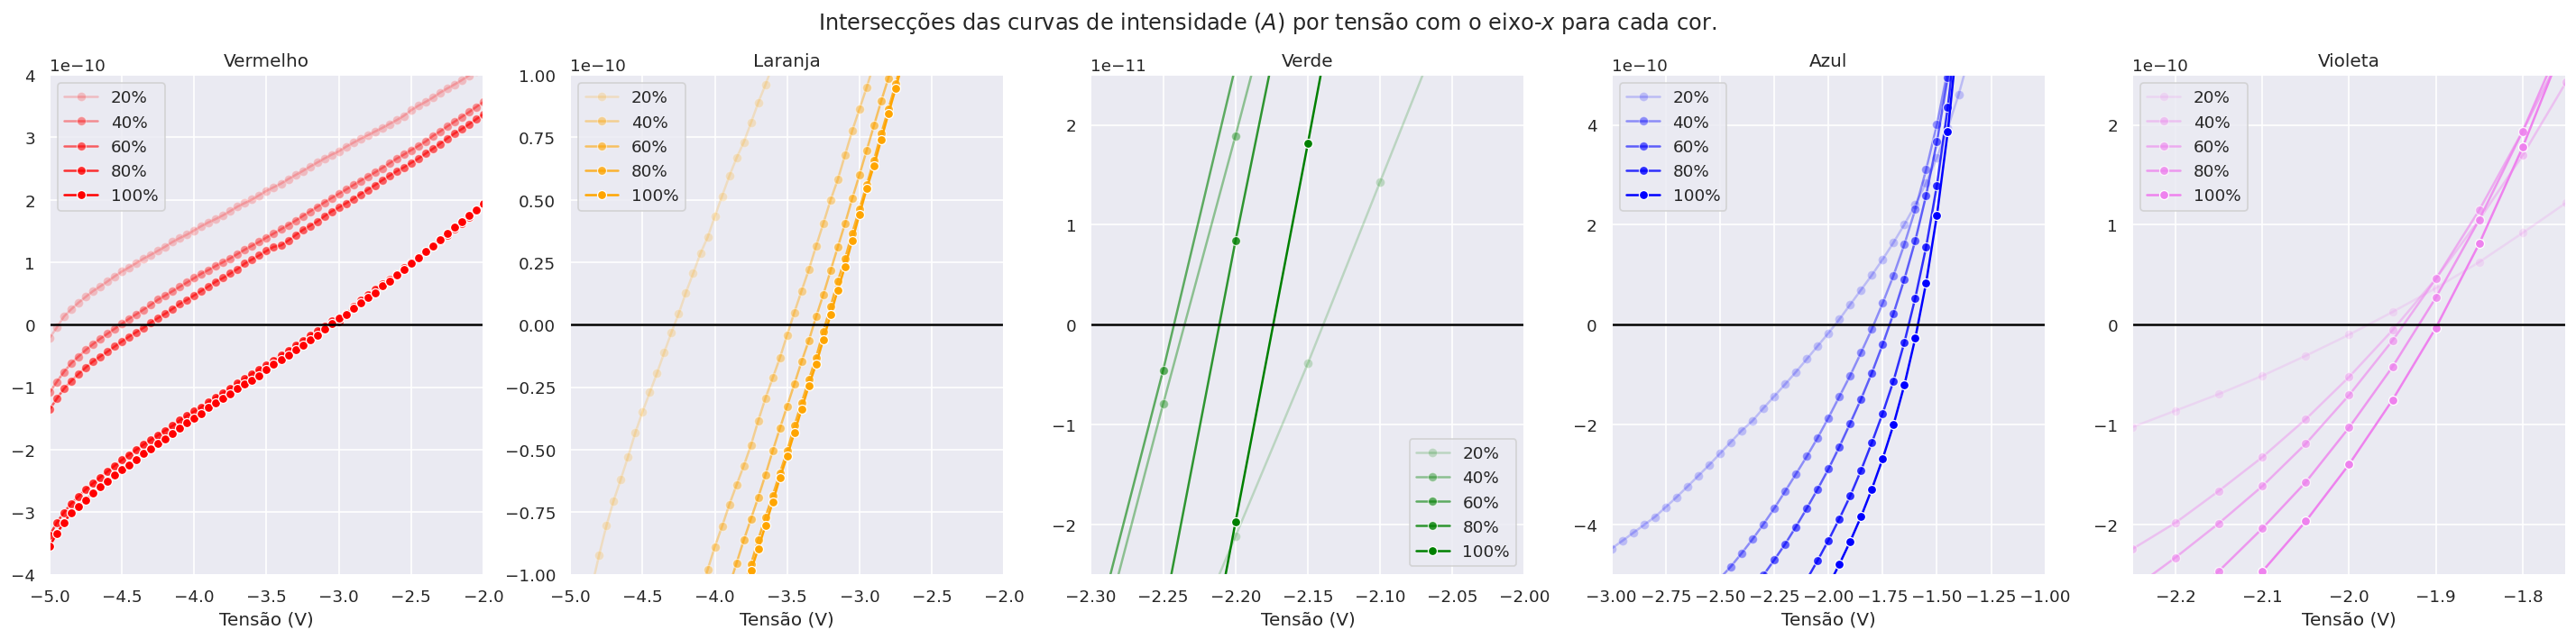

In [527]:
fig, axs = plt.subplots(1, len(cores), figsize=(30,6), gridspec_kw={  })
plt.suptitle('Intersecções das curvas de intensidade ($A$) por tensão com o eixo-$x$ para cada cor.')

xlims = [ (-5, -2), (-5, -2), (-2.3, -2.0), (-3, -1), (-2.25, -1.75) ]
ylims = [ (-0.4E-9, 0.4E-9), (-0.1E-9, 0.1E-9), (-0.25E-10, 0.25E-10), (-0.5E-9, 0.5E-9), (-0.25E-9, 0.25E-9) ]
for i,cor in enumerate(cores):

	for j,inte in enumerate(intensities):
		sns.lineplot(data=df, x='Tensao', y=f'{cor}_{inte}', color=colors_[i], marker='o', alpha=inte/100, label=f'{inte}%', ax=axs[i])

	axs[i].hlines(y=0, xmin=-5, xmax=5, color='black')
	axs[i].set( xlim=xlims[i], ylim=ylims[i], title=cor, xlabel='Tensão (V)', ylabel='')

plt.savefig('Plots/curves_intersection_x.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [472]:
cutoffs = []

for i,color in enumerate(cores):
	v0s = []
	sv0s = []

	for j,ints in enumerate(intensities):
		a = np.array(df[f'{color}_{ints}'])
		v0s.append( df['Tensao'][ np.where(np.diff(np.sign(a)))[0][0]])
	
	cutoffs.append([ np.mean(v0s), np.std(v0s) + 0.05 ])

cutoffs = np.array(cutoffs)

In [473]:
popt, pcov = curve_fit(
    lambda x, a, b: x * a + b,
    xdata=leds_frequency.transpose()[0],
    ydata=cutoffs.transpose()[0],
	sigma=cutoffs.transpose()[1]
)

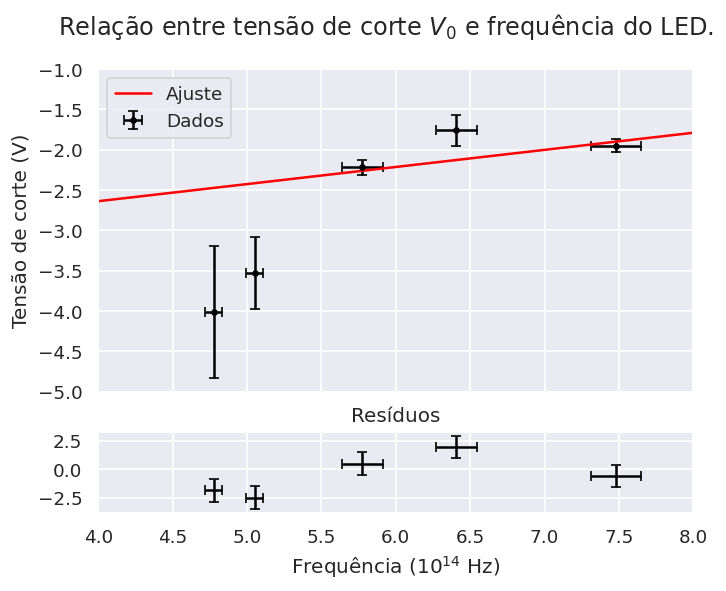

In [480]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.2, 'height_ratios': (4, 1)})
plt.suptitle('Relação entre tensão de corte $V_0$ e frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker='.', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / cutoffs.transpose()[1],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker=' ', color='black', capsize=3
)

axs[0].set(ylabel='Tensão de corte (V)', ylim=(-5, -1))
axs[1].set(xlim=(4, 8), xlabel='Frequência ($10^{14}$ Hz)', ylabel='', title='Resíduos')

plt.savefig('Plots/cutoff_intensity_method1.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [356]:
print('Constante de Planck:\t{:.8e} | {:.8e} | {:.2f}% | {:.1f}'.format(popt[0]*e, np.sqrt(pcov[0][0])*e, 100*(h-popt[0])/h, (h - popt[0]) / np.sqrt(pcov[0][0])))
print('Funçãpo Trabalho:\t{:.8e} | {:.8e}'.format(-popt[1]*e, np.sqrt(pcov[1][1])*e))

Constante de Planck:	3.40034428e-34 | 2.35668174e-34 | 48.68% | 1.4
Funçãpo Trabalho:	7.18942624e-19 | 1.57869859e-19


In [357]:
chi2 = np.sum((cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1])**2 / cutoffs.transpose()[1]**2)
print(chi2)

14.147316750571347


In [344]:
print(chi2 / 3)

4.715772250190448


### Método 2

In [494]:
cutoffs = []

for i,cor in enumerate(cores):
	v0s = []

	for i in intensities:
		name = f'{cor}_{i}'
		linear = lambda x, a, b: a * x + b

		data1 = df.loc[(df['Tensao'] < 0) & (df[name] > 0)]
		data2 = df.loc[(df['Tensao'] < 0) & (df[name] < 0)]

		fit1 = curve_fit(linear, xdata=data1['Tensao'], ydata=data1[name])
		fit2 = curve_fit(linear, xdata=data2['Tensao'], ydata=data2[name])

		(a, b), (c, d) = fit1[0], fit2[0]

		v0 = (d - b) / (a - c)
		v0s.append(v0)

	cutoffs.append([ np.mean(v0s), np.std(v0s) + 0.05 ])

cutoffs = np.array(cutoffs)

/home/ivfreire/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [496]:
popt, pcov = curve_fit(
	lambda x, a, b: a * x + b,
	xdata=leds_frequency.transpose()[0][1:],
	ydata=cutoffs.transpose()[0][1:],
	sigma=cutoffs.transpose()[1][1:]
)

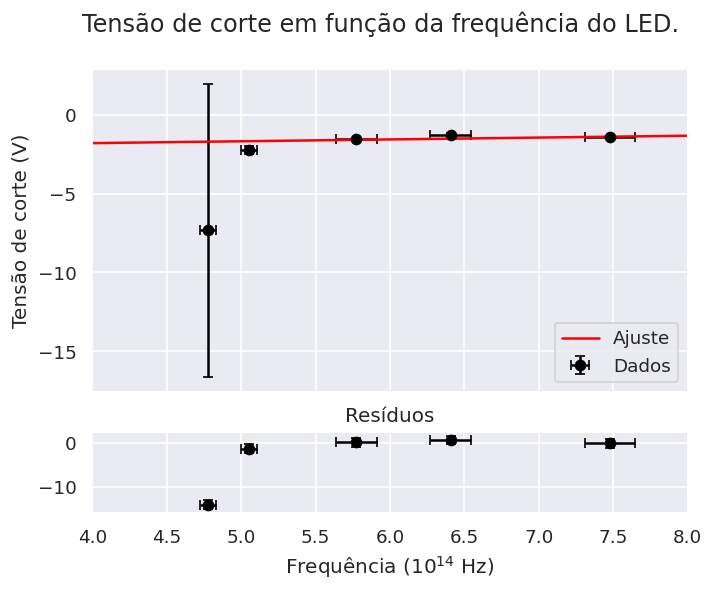

In [497]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.2, 'height_ratios': (4, 1)})
plt.suptitle('Tensão de corte em função da frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker='o', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / 0.4,
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker='o', color='black', capsize=3
)

axs[0].set(ylabel='Tensão de corte (V)')
axs[1].set(xlim=(4, 8), xlabel='Frequência ($10^{14}$ Hz)', ylabel='', title='Resíduos')

plt.savefig('Plots/cutoff_intensity_method2.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [498]:
popt[0] * e

1.8816480898728494e-34

### Método 3

O terceiro método consiste em determinar os pontos de intersecção entre os pares de linha para cada cor e intensidade, e assim, determinar o valor de $V_0$.

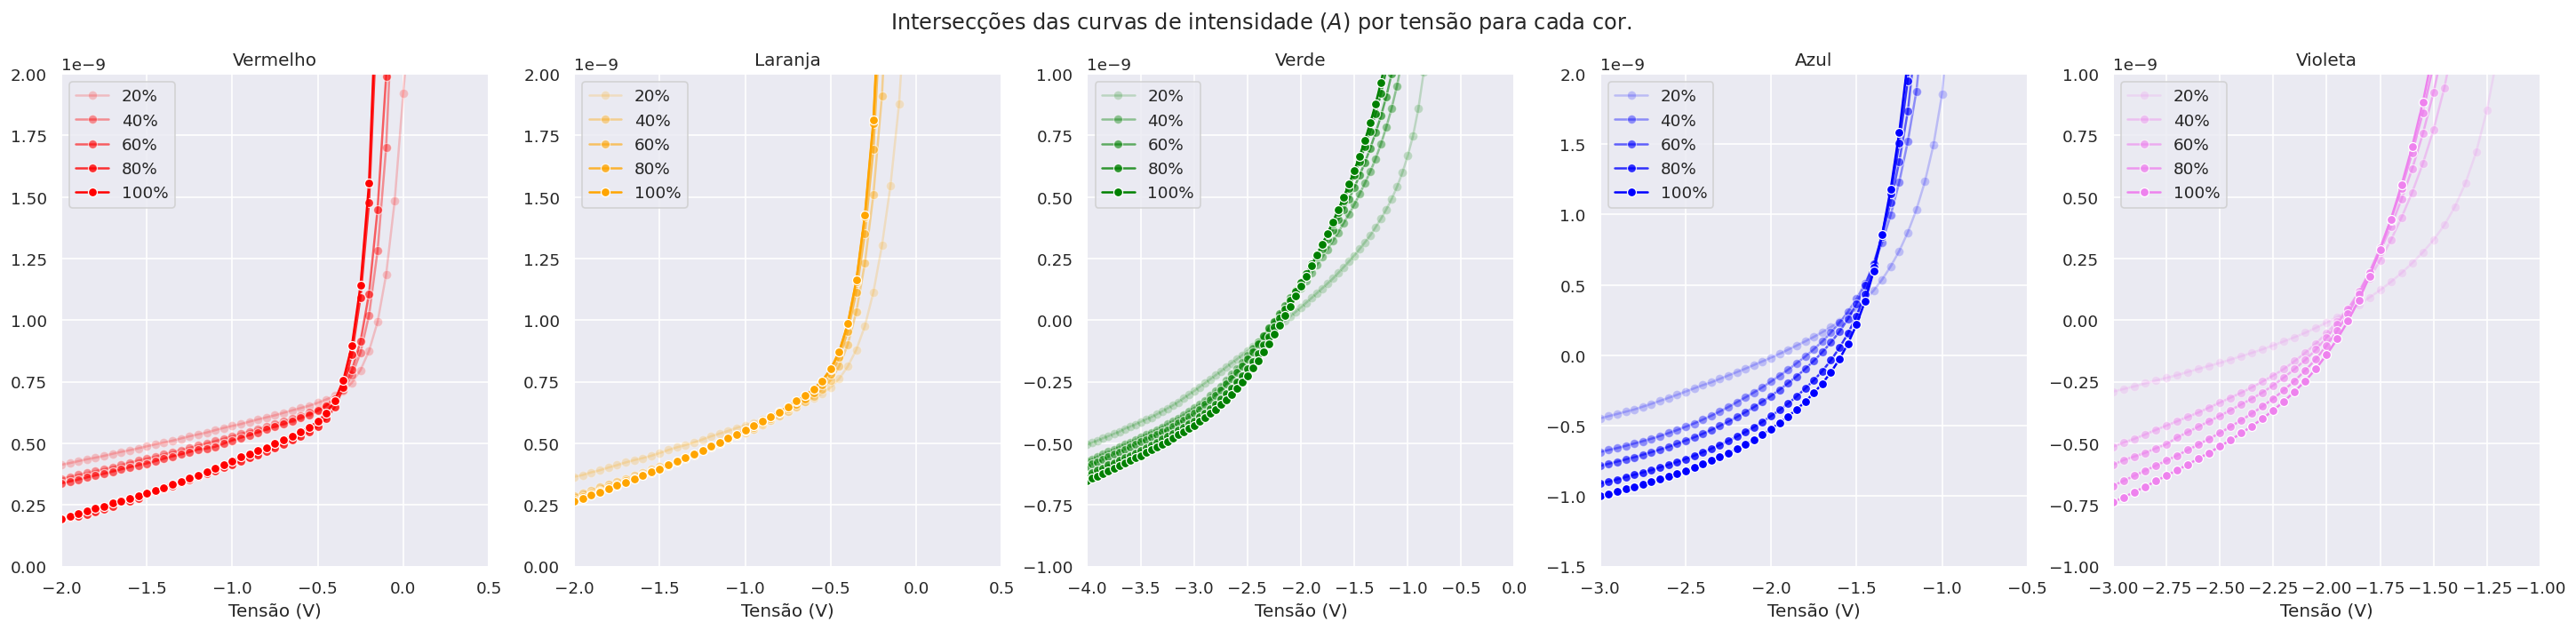

In [523]:
fig, axs = plt.subplots(1, len(cores), figsize=(30,6), gridspec_kw={  })
plt.suptitle('Intersecções das curvas de intensidade ($A$) por tensão para cada cor.')

xlims = [ (-2, 0.5), (-2, 0.5), (-4, 0), (-3, -0.5), (-3, -1) ]
ylims = [ (0, 2E-9), (0E-9, 2E-9), (-1E-9, 1E-9), (-1.5E-9, 2E-9), (-1E-9, 1E-9) ]
for i,cor in enumerate(cores):

	for j,inte in enumerate(intensities):
		sns.lineplot(data=df, x='Tensao', y=f'{cor}_{inte}', color=colors_[i], marker='o', alpha=inte/100, label=f'{inte}%', ax=axs[i])

	axs[i].set( xlim=xlims[i], ylim=ylims[i], title=cor, xlabel='Tensão (V)', ylabel='')

plt.savefig('Plots/curves_intersection.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [499]:
cutoffs = list([])

for i,cor in enumerate(cores):
	data = []

	for j,intensity in enumerate(intensities):
		name = f'{cor}_{intensity}'
		data.append(list(df[name]))
	data = np.array(data)

	v0s = []
	for j in range(len(data)):
		for k in range(j+1, len(data)):
			delta = -np.abs(data[k] - data[j])
			v0s.append( df['Tensao'][np.argmax(delta)] )

	cutoffs.append([ np.mean(v0s), np.std(v0s) ])

cutoffs = np.array(cutoffs)

In [500]:
popt, pcov = curve_fit(
	lambda x, a, b: a * x + b,
	xdata=leds_frequency.transpose()[0],
	ydata=cutoffs.transpose()[0]
)

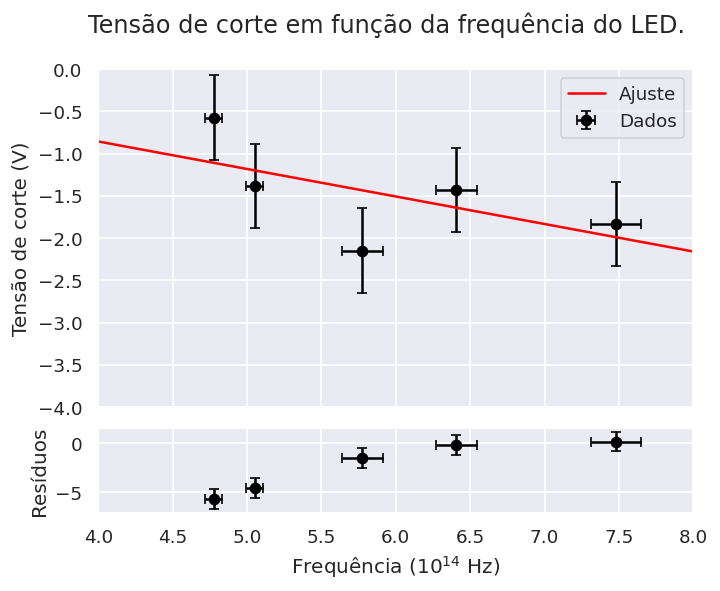

In [501]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4, 1)})
plt.suptitle('Tensão de corte em função da frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=0.5,
    fmt=' ', marker='o', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoff_voltages - leds_frequency.transpose()[0] * popt[0] - popt[1]) / 0.5,
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker='o', color='black', capsize=3
)

axs[0].set(ylabel='Tensão de corte (V)', ylim=(-4, 0))
axs[1].set(xlim=(4, 8), xlabel='Frequência ($10^{14}$ Hz)', ylabel='Resíduos')

plt.savefig('Plots/cutoff_intensity_method3.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Método 4 - 2ª Aula